In [1]:
import pandas as pd
import os
import string
import nltk
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

In [2]:
lyr_data = pd.read_csv(r'D:\unprocessed_lyrics.txt')

In [3]:
genre_num={'Rock':0, 'Pop':1 , 'Hip Hop':2}
lyr_final=lyr_data.map(lambda x: genre_num.get(x) if x in genre_num else x)
lyr_final=lyr_final.drop(['lyric_length'],axis=1)
lyr_final

,SName,Lyric,Genre,Artist
0,W.A.Y.S,At forty-four minutes to four. An angel walked...,2,Jhene Aiko
1,Two Wrongs,Intro:. (Wyclef). I'm just sittin' here playin...,2,Wyclef Jean
2,Triumphant (Get 'em),"Get 'em, get 'em, get 'em. Hit 'em, hit 'em, h...",2,Meek Mill
3,St. Tropez,Roll up and smoke my sins away. I'd like to go...,2,J. Cole
4,G-Unit Soldiers,"f/ Lloyd Banks, Tony Yayo (G-Unit). [Tony Yayo...",2,50 Cent
...,...,...,...,...
44383,Rock This Town,Well my baby and me went out late Saturday nig...,0,Stray Cats
44384,On The Other Side,I'm tired of everyone I know. Of everyone I se...,0,The Strokes
44385,Kentucky Rain,Seven lonely days. And a dozen towns ago. I re...,0,Elvis Presley
44386,Stranger Things Have Happened,Goddamn this dusty room. This hazy afternoon. ...,0,Foo Fighters


In [4]:
lyr_final['Lyric']=lyr_final['Lyric'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()]",' ')
lyr_final['Lyric']=lyr_final['Lyric'].str.replace("\[(.*?)\]",' ')
lyr_final['Lyric']=lyr_final['Lyric'].str.replace("' | '",' ')
lyr_final['Lyric']=lyr_final['Lyric'].str.replace('x[0-9]+',' ')

lyr_final=lyr_final[~lyr_final['Lyric'].str.contains(r'[^\x00-\x7F]+')]
lyr_final=lyr_final[lyr_final['Lyric'].str.strip()!='']

stop=stopwords.words('english')
lyr_final['Lyric']=lyr_final['Lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

def lemma(text,flag=True):
  l_text=text.split()
  if flag == True:
    lem=nltk.stem.wordnet.WordNetLemmatizer()
    l_text=[lem.lemmatize(word) for word in l_text]
  text=" ".join(l_text)
  return text

lyr_final['Lyric']=lyr_final['Lyric'].apply(lambda x: lemma(x))
lyr_final


,SName,Lyric,Genre,Artist
0,W.A.Y.S,At forty-four minute four. An angel walked doo...,2,Jhene Aiko
1,Two Wrongs,Intro:. (Wyclef). I'm sittin' playin' guitar. ...,2,Wyclef Jean
2,Triumphant (Get 'em),"Get 'em, get 'em, get 'em. Hit 'em, hit 'em, h...",2,Meek Mill
3,St. Tropez,Roll smoke sin away. I'd like go St. Tropez. M...,2,J. Cole
4,G-Unit Soldiers,"f/ Lloyd Banks, Tony Yayo (G-Unit). [Tony Yayo...",2,50 Cent
...,...,...,...,...
44382,FEELS LIKE,I feel sadness. From I said you. I'm drinking ...,0,Uriah Heep
44383,Rock This Town,Well baby went late Saturday night. I hair pil...,0,Stray Cats
44384,On The Other Side,I'm tired everyone I know. Of everyone I see. ...,0,The Strokes
44385,Kentucky Rain,Seven lonely days. And dozen town ago. I reach...,0,Elvis Presley


In [5]:
lyr_final['Genre'].value_counts()

Genre
0    13584
1    13479
2    13161
Name: count, dtype: int64

In [10]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [9]:
my_dict = {
    'r': 0,
    'p': 1,
    'h': 2
}

def update_cat(x):
    return my_dict[x]

#lyr_final['Genre'] = lyr_final['Genre'].apply(lambda x: update_cat(x))

encode_dict = {}

def encode_cat(x):
    if x not in encode_dict:
        encode_dict[x] = len(encode_dict)
    return encode_dict[x]

lyr_final['ENCODE_CAT'] = lyr_final['Genre'].apply(lambda x: encode_cat(x))

In [27]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.Genre[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [28]:
size = lyr_final.shape[0]
train_texts = list(lyr_final.Lyric[:int(size*0.8)])
eval_texts = list(lyr_final.Lyric[int(size*0.8)+1:int(size*0.9)])
test_texts = list(lyr_final.Lyric[int(size*0.9)+1:])
train_labels = list(lyr_final.Genre[:int(size*0.8)])
eval_labels = list(lyr_final.Genre[int(size*0.8)+1:int(size*0.9)])
test_labels = list(lyr_final.Genre[int(size*0.9)+1:])

In [29]:
train_size = 0.8
train_dataset=lyr_final.sample(frac=train_size,random_state=200)
test_dataset=lyr_final.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(lyr_final.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (40224, 5)
TRAIN Dataset: (32179, 5)
TEST Dataset: (8045, 5)


In [30]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [50]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [33]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

torch.cuda.empty_cache()

In [51]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [35]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [36]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [37]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [38]:
for epoch in range(EPOCHS):
    train(epoch)

D:\nlp\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.4477779865264893
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 0: 97.37406383044843
Training Loss Epoch: 0.07092094826418884
Training Accuracy Epoch: 97.37406383044843


In [41]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0
    total = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0

    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()

            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)

            if _ % 5000 == 0:
                loss_step = tr_loss / nb_tr_steps
                accu_step = (n_correct * 100) / nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu

In [42]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 0.0003407609765417874
Validation Accuracy per 100 steps: 100.0
Validation Loss Epoch: 0.00033349697217105017
Validation Accuracy Epoch: 100.0
Accuracy on test data = 100.00%


D:\nlp\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


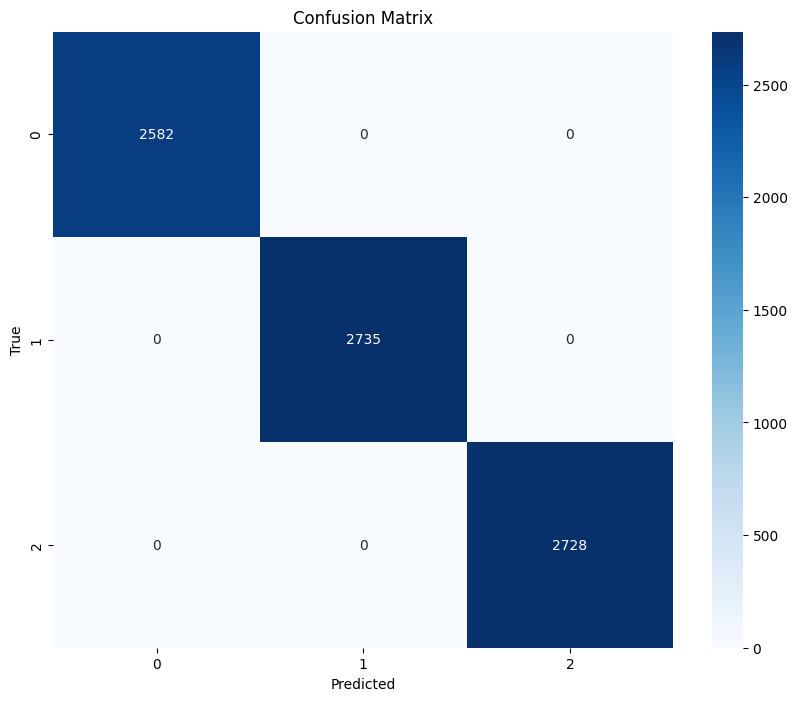

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a validation dataset named 'validation_loader'
validation_loader = testing_loader

# Set the model to evaluation mode
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for _, data in enumerate(validation_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)

        outputs = model(ids, mask).squeeze()
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
classes = ['0','1','2']  # Replace with your actual class labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
